In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout,BatchNormalization

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
columns = ['person', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11',\
       'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21',\
       'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c30', 'c31',\
       'c32', 'c33', 'c34', 'c35', 'c36', 'c37', 'c38', 'c39', 'c40', 'c41',\
       'c42', 'c43', 'c44', 'c45', 'c46', 'c47', 'c48', 'c49', 'c50', 'c51',\
       'c52', 'c53', 'c54', 'c55', 'c56', 'c57', 'c58', 'O']

In [3]:
max_rows, max_cols = 1034504, 59
#max_rows, max_cols = 884009, 59

In [4]:
# Pad the time series to the same length
x_padded = []
y_padded = []
for i in range(1,12):
    directory = '/kaggle/input/merged-data/' + str("{:03d}".format(i) + '.csv')
    df_chunk = pd.read_csv(directory).values
    
    x_padding = np.pad(df_chunk[:, :-1], ((0, max_rows - df_chunk.shape[0]), (0, 0)), 'constant')
    y_padding = np.pad(df_chunk[:, -1], ((0, max_rows - df_chunk.shape[0])), 'constant')

    
    print(df_chunk.shape, x_padding.shape, y_padding.shape)
    x_padded.append(x_padding)
    y_padded.append(y_padding)

x_padded = np.array(x_padded)
y_padded = np.array(y_padded)

(376504, 60) (1034504, 59) (1034504,)
(268504, 60) (1034504, 59) (1034504,)
(1034504, 60) (1034504, 59) (1034504,)
(322005, 60) (1034504, 59) (1034504,)
(153004, 60) (1034504, 59) (1034504,)
(530504, 60) (1034504, 59) (1034504,)
(343004, 60) (1034504, 59) (1034504,)
(884009, 60) (1034504, 59) (1034504,)
(396006, 60) (1034504, 59) (1034504,)
(803504, 60) (1034504, 59) (1034504,)
(580504, 60) (1034504, 59) (1034504,)


In [5]:
sequence_length = 10 
num_features = 59

num_sequences = len(x_padded) // sequence_length
total_samples = num_sequences * sequence_length

xpadded = x_padded[:total_samples]
ypadded = y_padded[:total_samples]

X = xpadded.reshape(-1, sequence_length, num_features)
y = ypadded.reshape(-1, sequence_length)
X.shape, y.shape

((1034504, 10, 59), (1034504, 10))

In [6]:
#model
i = Input(shape=(10, 59))
x = LSTM(128, return_sequences = True)(i)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = LSTM(64, return_sequences = True)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)


'''x = LSTM(128, return_sequences = True)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)'''

x = Dense(1, activation = 'sigmoid')(x)

model = Model(i, x)

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 59)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 128)           96256     
                                                                 
 batch_normalization (BatchN  (None, 10, 128)          512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 64)           256       
 hNormalization)                                             

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
r = model.fit(X, y, epochs = 50, batch_size = 256, validation_split = 0.2, callbacks=[early_stopping])

Epoch 1/50
3233/3233 [==============================] - 45s 11ms/step - loss: 0.2302 - accuracy: 0.8945 - val_loss: 0.4371 - val_accuracy: 0.7724
Epoch 2/50
3233/3233 [==============================] - 34s 11ms/step - loss: 0.1984 - accuracy: 0.9084 - val_loss: 0.5019 - val_accuracy: 0.7452
Epoch 3/50
3233/3233 [==============================] - 34s 11ms/step - loss: 0.1924 - accuracy: 0.9119 - val_loss: 0.5880 - val_accuracy: 0.7434
Epoch 4/50
3233/3233 [==============================] - 34s 11ms/step - loss: 0.1860 - accuracy: 0.9161 - val_loss: 0.5218 - val_accuracy: 0.7612
Epoch 5/50
3233/3233 [==============================] - 34s 11ms/step - loss: 0.1835 - accuracy: 0.9172 - val_loss: 0.5041 - val_accuracy: 0.7714
Epoch 6/50
3233/3233 [==============================] - 34s 11ms/step - loss: 0.1811 - accuracy: 0.9188 - val_loss: 0.6046 - val_accuracy: 0.7544


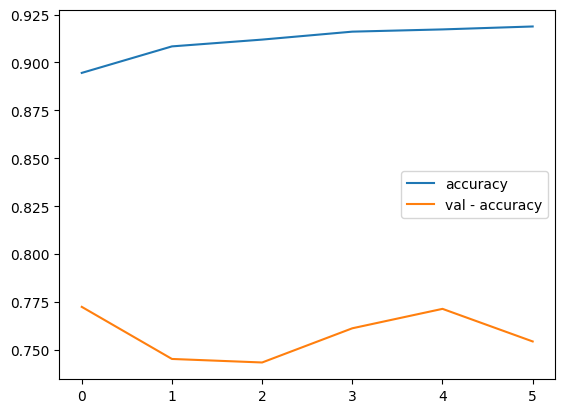

In [10]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val - accuracy')
plt.legend(loc = 'best')

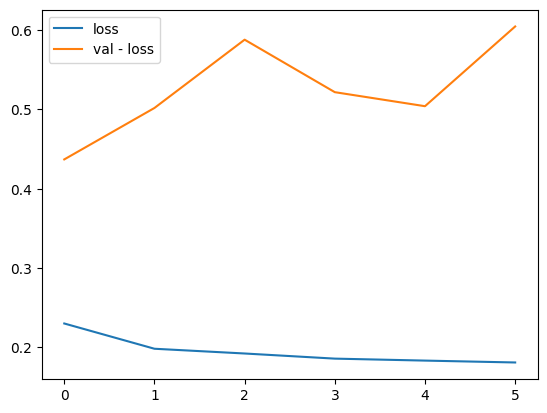

In [11]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val - loss')
plt.legend(loc = 'best')

In [12]:
test_data = pd.read_csv('/kaggle/input/merged-data/012.csv').values
x_test_padded = np.pad(test_data[:, :-1], ((0, max_rows - test_data.shape[0]), (0,0)), 'constant')
y_test_padded = np.pad(test_data[:, -1], ((0, max_rows - test_data.shape[0])), 'constant')
                      
print(x_test_padded.shape, y_test_padded.shape)

(1034504, 59) (1034504,)


In [13]:
num_sequences = len(x_test_padded) // sequence_length
total_samples = num_sequences * sequence_length

x_testpadded = x_test_padded[:total_samples]
y_testpadded = y_test_padded[:total_samples]

X_test = x_testpadded.reshape(-1, sequence_length, num_features)
y_test = y_testpadded.reshape(-1, sequence_length)
X_test.shape, y_test.shape

((103450, 10, 59), (103450, 10))

In [14]:
y_pred = model.predict(X_test)

3233/3233 [==============================] - 12s 3ms/step


In [15]:
y_pred = y_pred.reshape(-1, )
y_test = y_test.reshape(-1,)

In [16]:
y_pred_bool = [0 if x < 0.7 else 1 for x in y_pred]

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.reshape(-1,), y_pred_bool)

0.8727829869502175

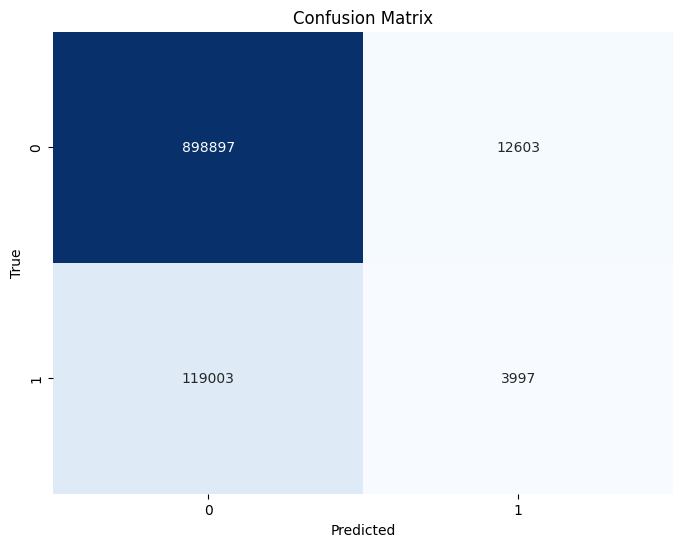

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_bool)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()